In [1]:
from AGSRNet_source.preprocessing import *
from AGSRNet_source.model import *
from AGSRNet_source.train import *

from data_preparation import load_data_tensor

from sklearn.model_selection import KFold

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"CUDA available... Using {DEVICE}!")
else:
    DEVICE = torch.device('cpu')
    print(f"CUDA not available... Using {DEVICE}!")

CUDA available... Using cuda!


In [3]:
# get the data
lr_train, lr_test, hr_train = load_data_tensor('data')
lr_train, lr_test, hr_train = lr_train.to(DEVICE), lr_test.to(DEVICE), hr_train.to(DEVICE)
# lr_train: training input x_train
# hr_train: training target y_train
# lr_test: test input x_test

In [4]:
print(f'lr_train: {type(lr_train)}, lr_test: {type(lr_test)}, hr_train: {type(hr_train)}')
print(f'lr_train: {lr_train.shape}, lr_test: {lr_test.shape}, hr_train: {hr_train.shape}')

lr_train: <class 'torch.Tensor'>, lr_test: <class 'torch.Tensor'>, hr_train: <class 'torch.Tensor'>
lr_train: torch.Size([167, 160, 160]), lr_test: torch.Size([112, 160, 160]), hr_train: torch.Size([167, 268, 268])


In [5]:
lr_train[0].numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

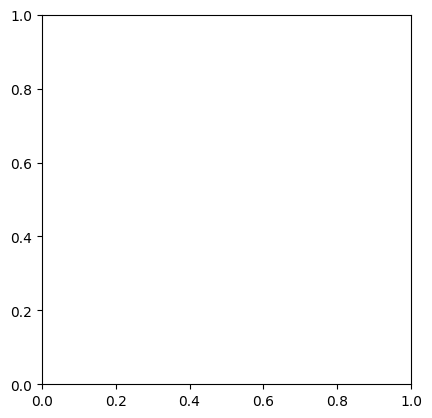

In [6]:
# plotting the LR and target HR matrix for 1 sample/participant (index=0)
plt.imshow(lr_train[0], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(hr_train[0], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
# unnecessary, but just to be consistent with the AGSR-Net repo

# actual data
subjects_adj, subjects_ground_truth, test_adj, test_ground_truth = \
    lr_train, hr_train, lr_test, None  # we don't have the test labels, right?


# simulated data from the AGSR-Net repo 
# subjects_adj = np.random.normal(0.5, 1, (190, 160, 160))
# test_adj = np.random.normal(0.5, 1, (87, 160, 160))
# subjects_ground_truth = np.random.normal(0.5, 1, (190, 268, 268))
# test_ground_truth = np.random.normal(0.5, 1, (87, 268, 268))

In [6]:
# create the model
ks = [0.9, 0.7, 0.6, 0.5]

# default values from demo.py in the GitHub repo:
# https://github.com/basiralab/AGSR-Net/blob/master/demo.py
# args = {
#     'epochs': 200,
#     'lr': 0.0001,
#     'lmbda': 0.1,
#     'lr_dim': 160,
#     'hr_dim': 320,
#     'hidden_dim': 320,
#     'padding': 26,
#     'mean_dense': 0.,
#     'std_dense': 0.01,
#     'mean_gaussian': 0.,
#     'std_gaussian': 0.1
# }

class ModelArgs:  # instead of using arg parser, so that this works with AGSRNet class
    def __init__(self, epochs, lr, splits, lmbda, lr_dim, hr_dim, hidden_dim,
                 padding, mean_dense, std_dense, mean_gaussian, std_gaussian):
        self.epochs = epochs
        self.lr = lr
        self.splits = splits
        self.lmbda = lmbda
        self.lr_dim = lr_dim
        self.hr_dim = hr_dim
        self.hidden_dim = hidden_dim
        self.padding = padding
        self.mean_dense = mean_dense
        self.std_dense = std_dense
        self.mean_gaussian = mean_gaussian
        self.std_gaussian = std_gaussian

# default arguments
args = ModelArgs(
    epochs=200,
    lr=0.0001,
    splits=3,
    lmbda=0.1,
    lr_dim=160,
    hr_dim=320,
    hidden_dim=320,
    padding=26,
    mean_dense=0.,
    std_dense=0.01,
    mean_gaussian=0.,
    std_gaussian=0.1
)

model = AGSRNet(ks, args).to(DEVICE)
print(model)

AGSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gcn): GCN(
      (proj): Linear(in_features=160, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (bottom_gcn): GCN(
      (proj): Linear(in_features=320, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (end_gcn): GCN(
      (proj): Linear(in_features=640, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
  )
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
)


In [8]:
# train the model
#train(model, subjects_adj.numpy(), subjects_ground_truth.numpy(), args)

In [9]:
# test the model
# test(model, test_adj, test_ground_truth, args)

In [7]:
cv = KFold(n_splits=args.splits, random_state=42, shuffle=True)
X, Y = lr_train, hr_train

def train_model():
    for train_index, test_index in cv.split(X):
        subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = \
            X[train_index], X[test_index], Y[train_index], Y[test_index]
        train(model, subjects_adj, subjects_ground_truth, args)
        test(model, test_adj, test_ground_truth, args)

train_model()

TypeError: Parameter.__new__() got an unexpected keyword argument 'device'

In [11]:
model

AGSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gcn): GCN(
      (proj): Linear(in_features=160, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (bottom_gcn): GCN(
      (proj): Linear(in_features=320, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (end_gcn): GCN(
      (proj): Linear(in_features=640, out_features=320, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
  )
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
)

In [16]:
re = unpad(model(lr_test[0], args.lr_dim, args.hr_dim)[0], args.padding)
re.shape

torch.Size([268, 268])